In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListChb
from lib.signals import EegProcessorChb
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.bss import IWasobi
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/chb-mit/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-02-17 14:17:31,348 - root - INFO - Recording contains channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']


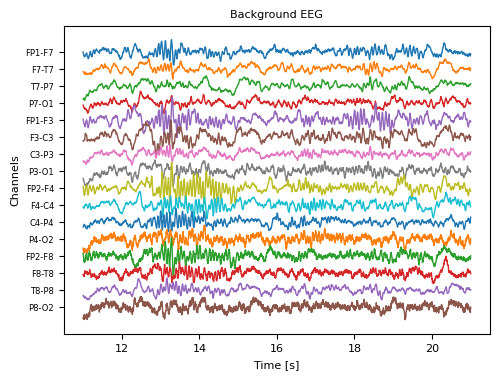

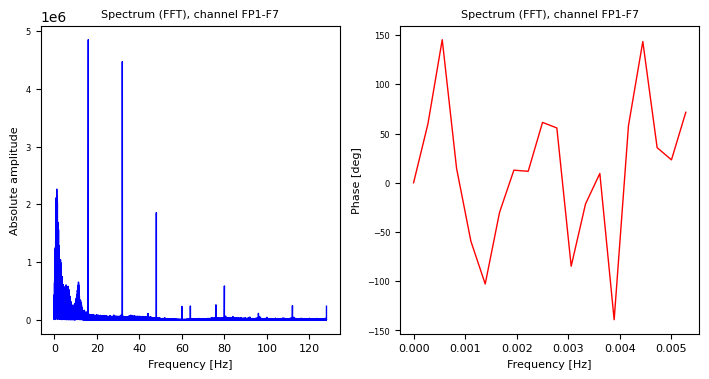

In [2]:
PATIENT = "chb01"
FILENAME = "chb01_03.edf"
PERIOD = [11, 21]

###########################################################
metadata = MetadataListChb()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorChb(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1-F7")

### * Resample the EEG to 256Hz

2025-02-17 14:17:44,352 - root - INFO - Dowsampling factor is = 1


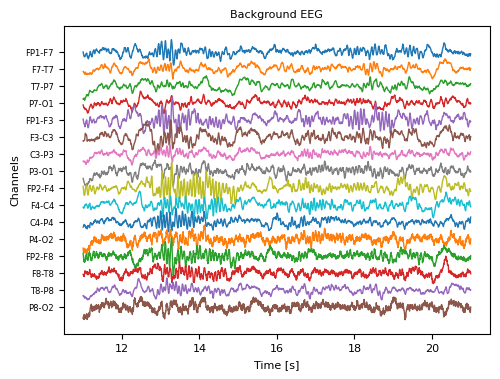

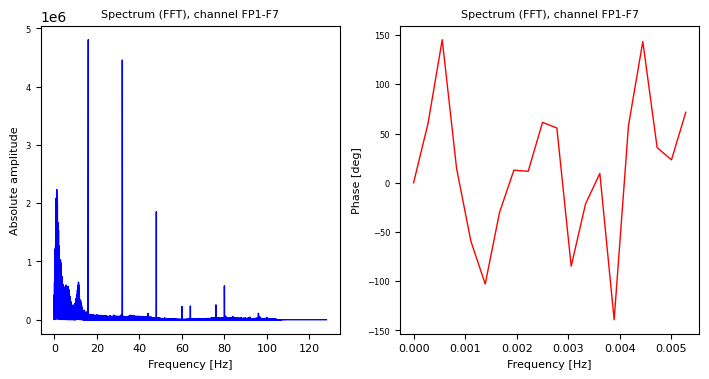

In [3]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1-F7")

### * Remove the drift noise, high frequency oscillations, power line noise

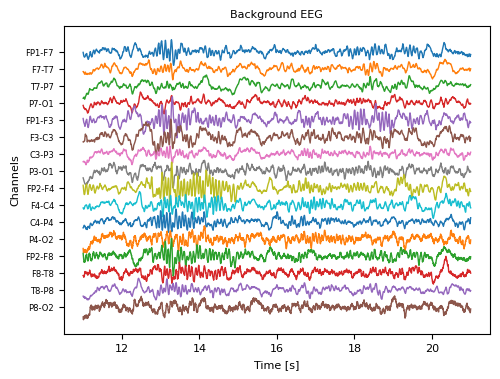

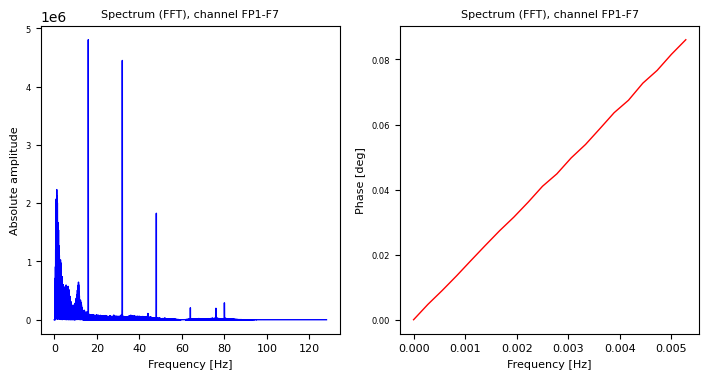

In [4]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1-F7")

### Compute sources by using iWASOBI

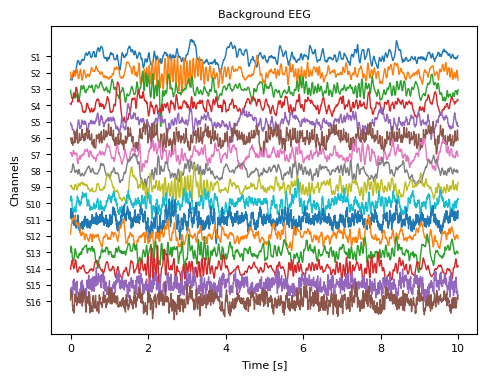

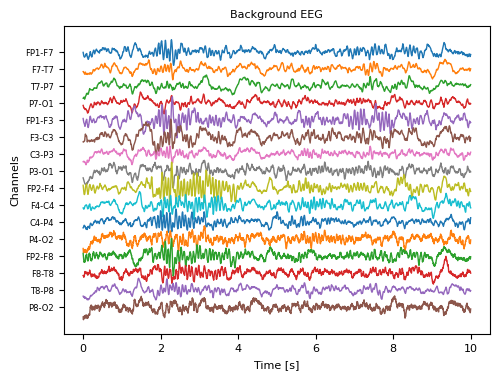

In [10]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
#eeg_sources[0, :] = 0
#eeg_sources[1, :] = 0
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

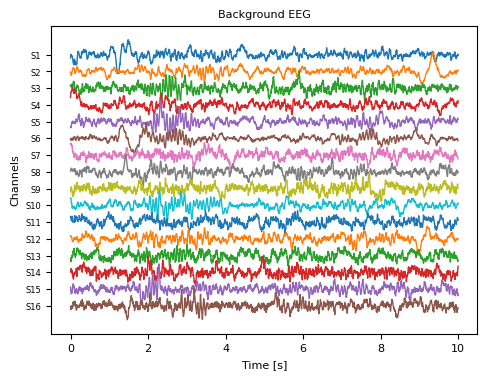

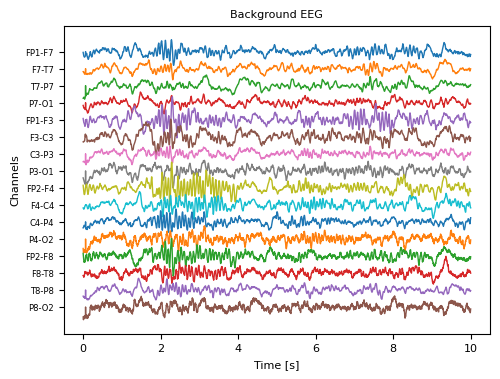

In [8]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])